In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install kaggle

In [3]:
!mkdir  ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

 99% 782M/788M [00:09<00:00, 72.0MB/s]
100% 788M/788M [00:09<00:00, 86.0MB/s]


In [7]:
import zipfile
zip_ref = zipfile.ZipFile('/content/microsoft-catsvsdogs-dataset.zip', 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import os
import PIL
from PIL import Image

import random
%matplotlib inline
import cv2
import datetime

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, Activation, BatchNormalization, ZeroPadding2D
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras import regularizers, optimizers
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping,LearningRateScheduler,CSVLogger,LambdaCallback,TensorBoard
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

import time
import glob
import matplotlib.image as matimage
import plotly.express as px

In [9]:
!pip install rembg
import rembg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.3 MB/s eta 0:00:00


In [10]:
!pip3 install livelossplot
from livelossplot import PlotLossesKeras

In [11]:
img = cv2.imread("PetImages/Dog/12499.jpg")
type(img)

numpy.ndarray

In [12]:
img = cv2.imread("PetImages/Cat/12499.jpg")
type(img)

numpy.ndarray

In [13]:
img_folder = r'PetImages/'

In [14]:
def explore_class(class_name:str, nsamples:int):

    if nsamples%5 == 0:
        nrows = int(nsamples/5)
    else:
        nrows = int(nsamples//5 + 1)

    path = f'{img_folder}{class_name}'
    plt.figure(figsize=(20,3.5*nrows))
    plt.suptitle(f"Class: {class_name}, number of samples: {len(os.listdir(path))}")
    for i in range(nsamples):
        file = random.choice(os.listdir(path))
        image_path= os.path.join(path, file)
        img=cv2.imread(image_path)
        image_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        ax=plt.subplot(nrows,5,i+1)
        ax.title.set_text(file)

        plt.imshow(image_rgb)

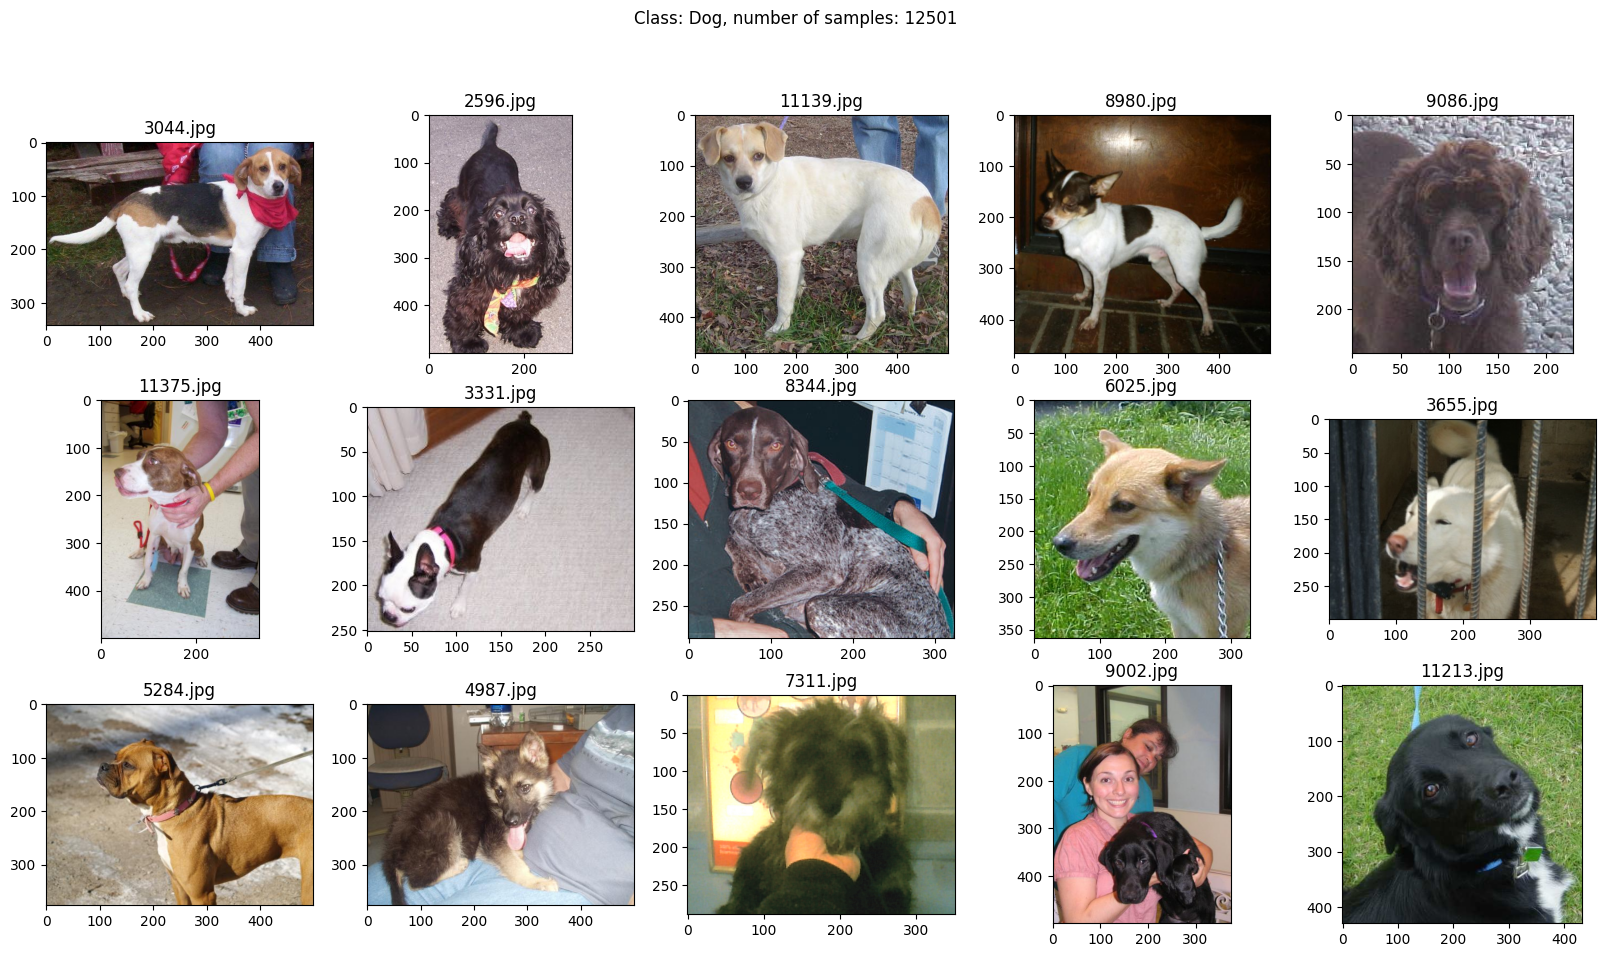

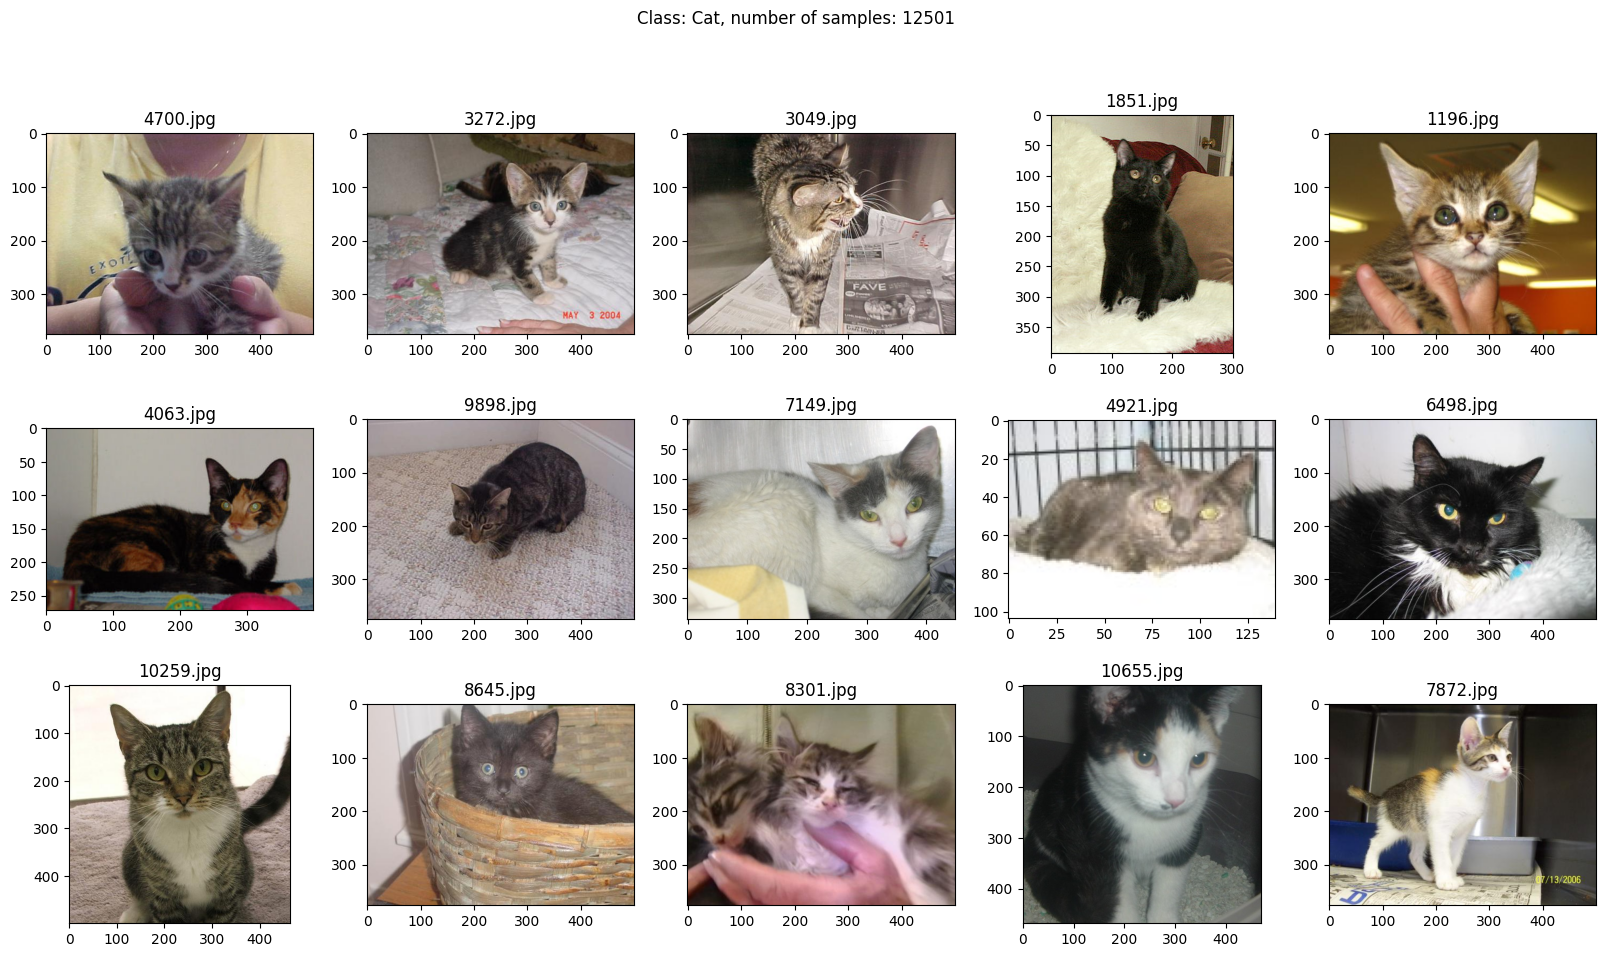

In [15]:
explore_class('Dog',15)
explore_class('Cat',15)

In [16]:
counter = {}

def count_size(img_folder,counter):

    for dir in os.listdir(img_folder):
        counter[dir]={}
        for file in os.listdir(os.path.join(img_folder, dir)):
            image_path= os.path.join(img_folder, dir,  file)
            image=cv2.imread(image_path)
            size = img.shape
            if size not in counter[dir]:
                counter[dir][size]=1
            else:
                counter[dir][size]+=1

In [17]:
count_size(img_folder,counter)
counter

{'Dog': {(419, 408, 3): 12501}, 'Cat': {(419, 408, 3): 12501}}

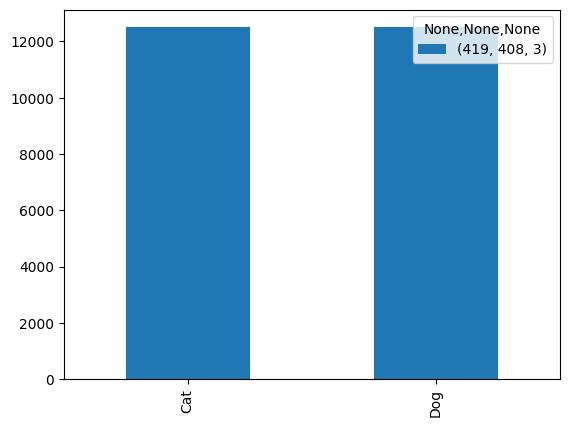

In [18]:
df = pd.DataFrame.from_dict(counter, orient='index')
df.plot(kind='bar')
pass

In [19]:
SOURCE_PATH = '/content/PetImages'

In [20]:
SOURCE_PATH = '/content/PetImages'

# os.listdir returns a list containing all files under the given path
start = time.time()
CAT_PATH = os.listdir(os.path.join(SOURCE_PATH, 'Cat'))
DOG_PATH = os.listdir(os.path.join(SOURCE_PATH, 'Dog'))

CAT_PATH = list(map(lambda x : os.path.join(SOURCE_PATH+"/Cat", x), CAT_PATH))
DOG_PATH = list(map(lambda x : os.path.join(SOURCE_PATH+"/Dog", x), DOG_PATH))
end = time.time()

print(f"{len(CAT_PATH)} cats img")
print(f"{len(DOG_PATH)} dogs img")
print(f'\n{end-start} sec.')

12501 cats img
12501 dogs img

0.04037594795227051 sec.


In [21]:
df = pd.DataFrame({"path":CAT_PATH+DOG_PATH,"label":[0]*len(CAT_PATH)+[1]*len(DOG_PATH)})
df.head()

path  label
0   /content/PetImages/Cat/7289.jpg      0
1   /content/PetImages/Cat/9795.jpg      0
2   /content/PetImages/Cat/8122.jpg      0
3   /content/PetImages/Cat/7214.jpg      0
4  /content/PetImages/Cat/12122.jpg      0

In [22]:
df.shape

(25002, 2)

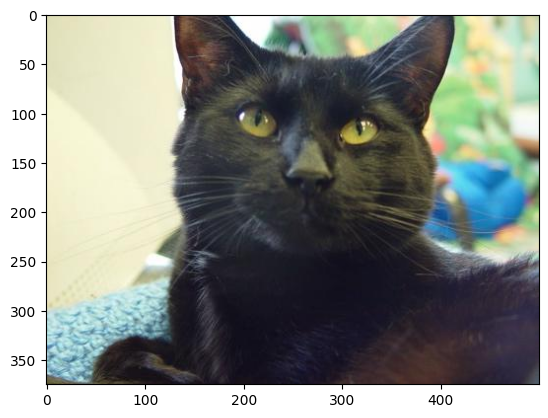

In [23]:
img = cv2.cvtColor(cv2.imread(df.iloc[0,0]), cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [24]:
def data_check():
    """
        check each image file for corrupted or missing
    """
    error = []
    start = time.time()
    for i in range(len(df)):
        try:                    # checks for corrupeted or missing image files
            if len(cv2.imread(df.iloc[i,0])) == 3:
                _ = 1
        except:
            print(i)
            error.append(df.iloc[i,0])
    end = time.time()
    print(f'\n{end-start} sec.')
    return error

In [25]:
remove = data_check()

425
670
2019
2026
2847
3398
5049
5066
5967
6289
6355
7123
7168
7589
7781
8234
8267
8650
8711
10171
10179
10668
10854
12085
12173
13098
13327
13602
13690
14066
14102
14703
14841
15132
16191
16592
16963
17805
18122
18193
19160
19992
20180
20413
20534
20673
21148
22811
22934
23175
23355
23490
23572
23752
24366
24555

56.475481033325195 sec.


In [26]:
df = df[~df["path"].isin(remove)]

In [27]:
df

path  label
0       /content/PetImages/Cat/7289.jpg      0
1       /content/PetImages/Cat/9795.jpg      0
2       /content/PetImages/Cat/8122.jpg      0
3       /content/PetImages/Cat/7214.jpg      0
4      /content/PetImages/Cat/12122.jpg      0
...                                 ...    ...
24997   /content/PetImages/Dog/6927.jpg      1
24998   /content/PetImages/Dog/7409.jpg      1
24999   /content/PetImages/Dog/6509.jpg      1
25000   /content/PetImages/Dog/2842.jpg      1
25001   /content/PetImages/Dog/2499.jpg      1

[24946 rows x 2 columns]

In [28]:
df['path'][12475:12477]

12500    /content/PetImages/Cat/2499.jpg
12501    /content/PetImages/Dog/7289.jpg
Name: path, dtype: object

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df['path'][11475:13477], df['label'][11475:13477], test_size=0.1, random_state=42)

df_train = pd.DataFrame({"path":X_train,"label":y_train})
df_test = pd.DataFrame({"path":X_test,"label":y_test})

df_train['label'] = df_train['label'].astype(str)
df_test['label'] = df_test['label'].astype(str)

In [30]:
train_datagen = ImageDataGenerator(rescale=1 / 255.0, validation_split=0.20)

In [31]:
test_datagen = ImageDataGenerator(rescale=1 / 255.0)

In [32]:
image_size = 224
input_shape = (image_size, image_size, 3)

epochs = 120
batch_size = 32

In [33]:
train_datagen_2 = ImageDataGenerator(
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

Found 1 validated image filenames belonging to 1 classes.


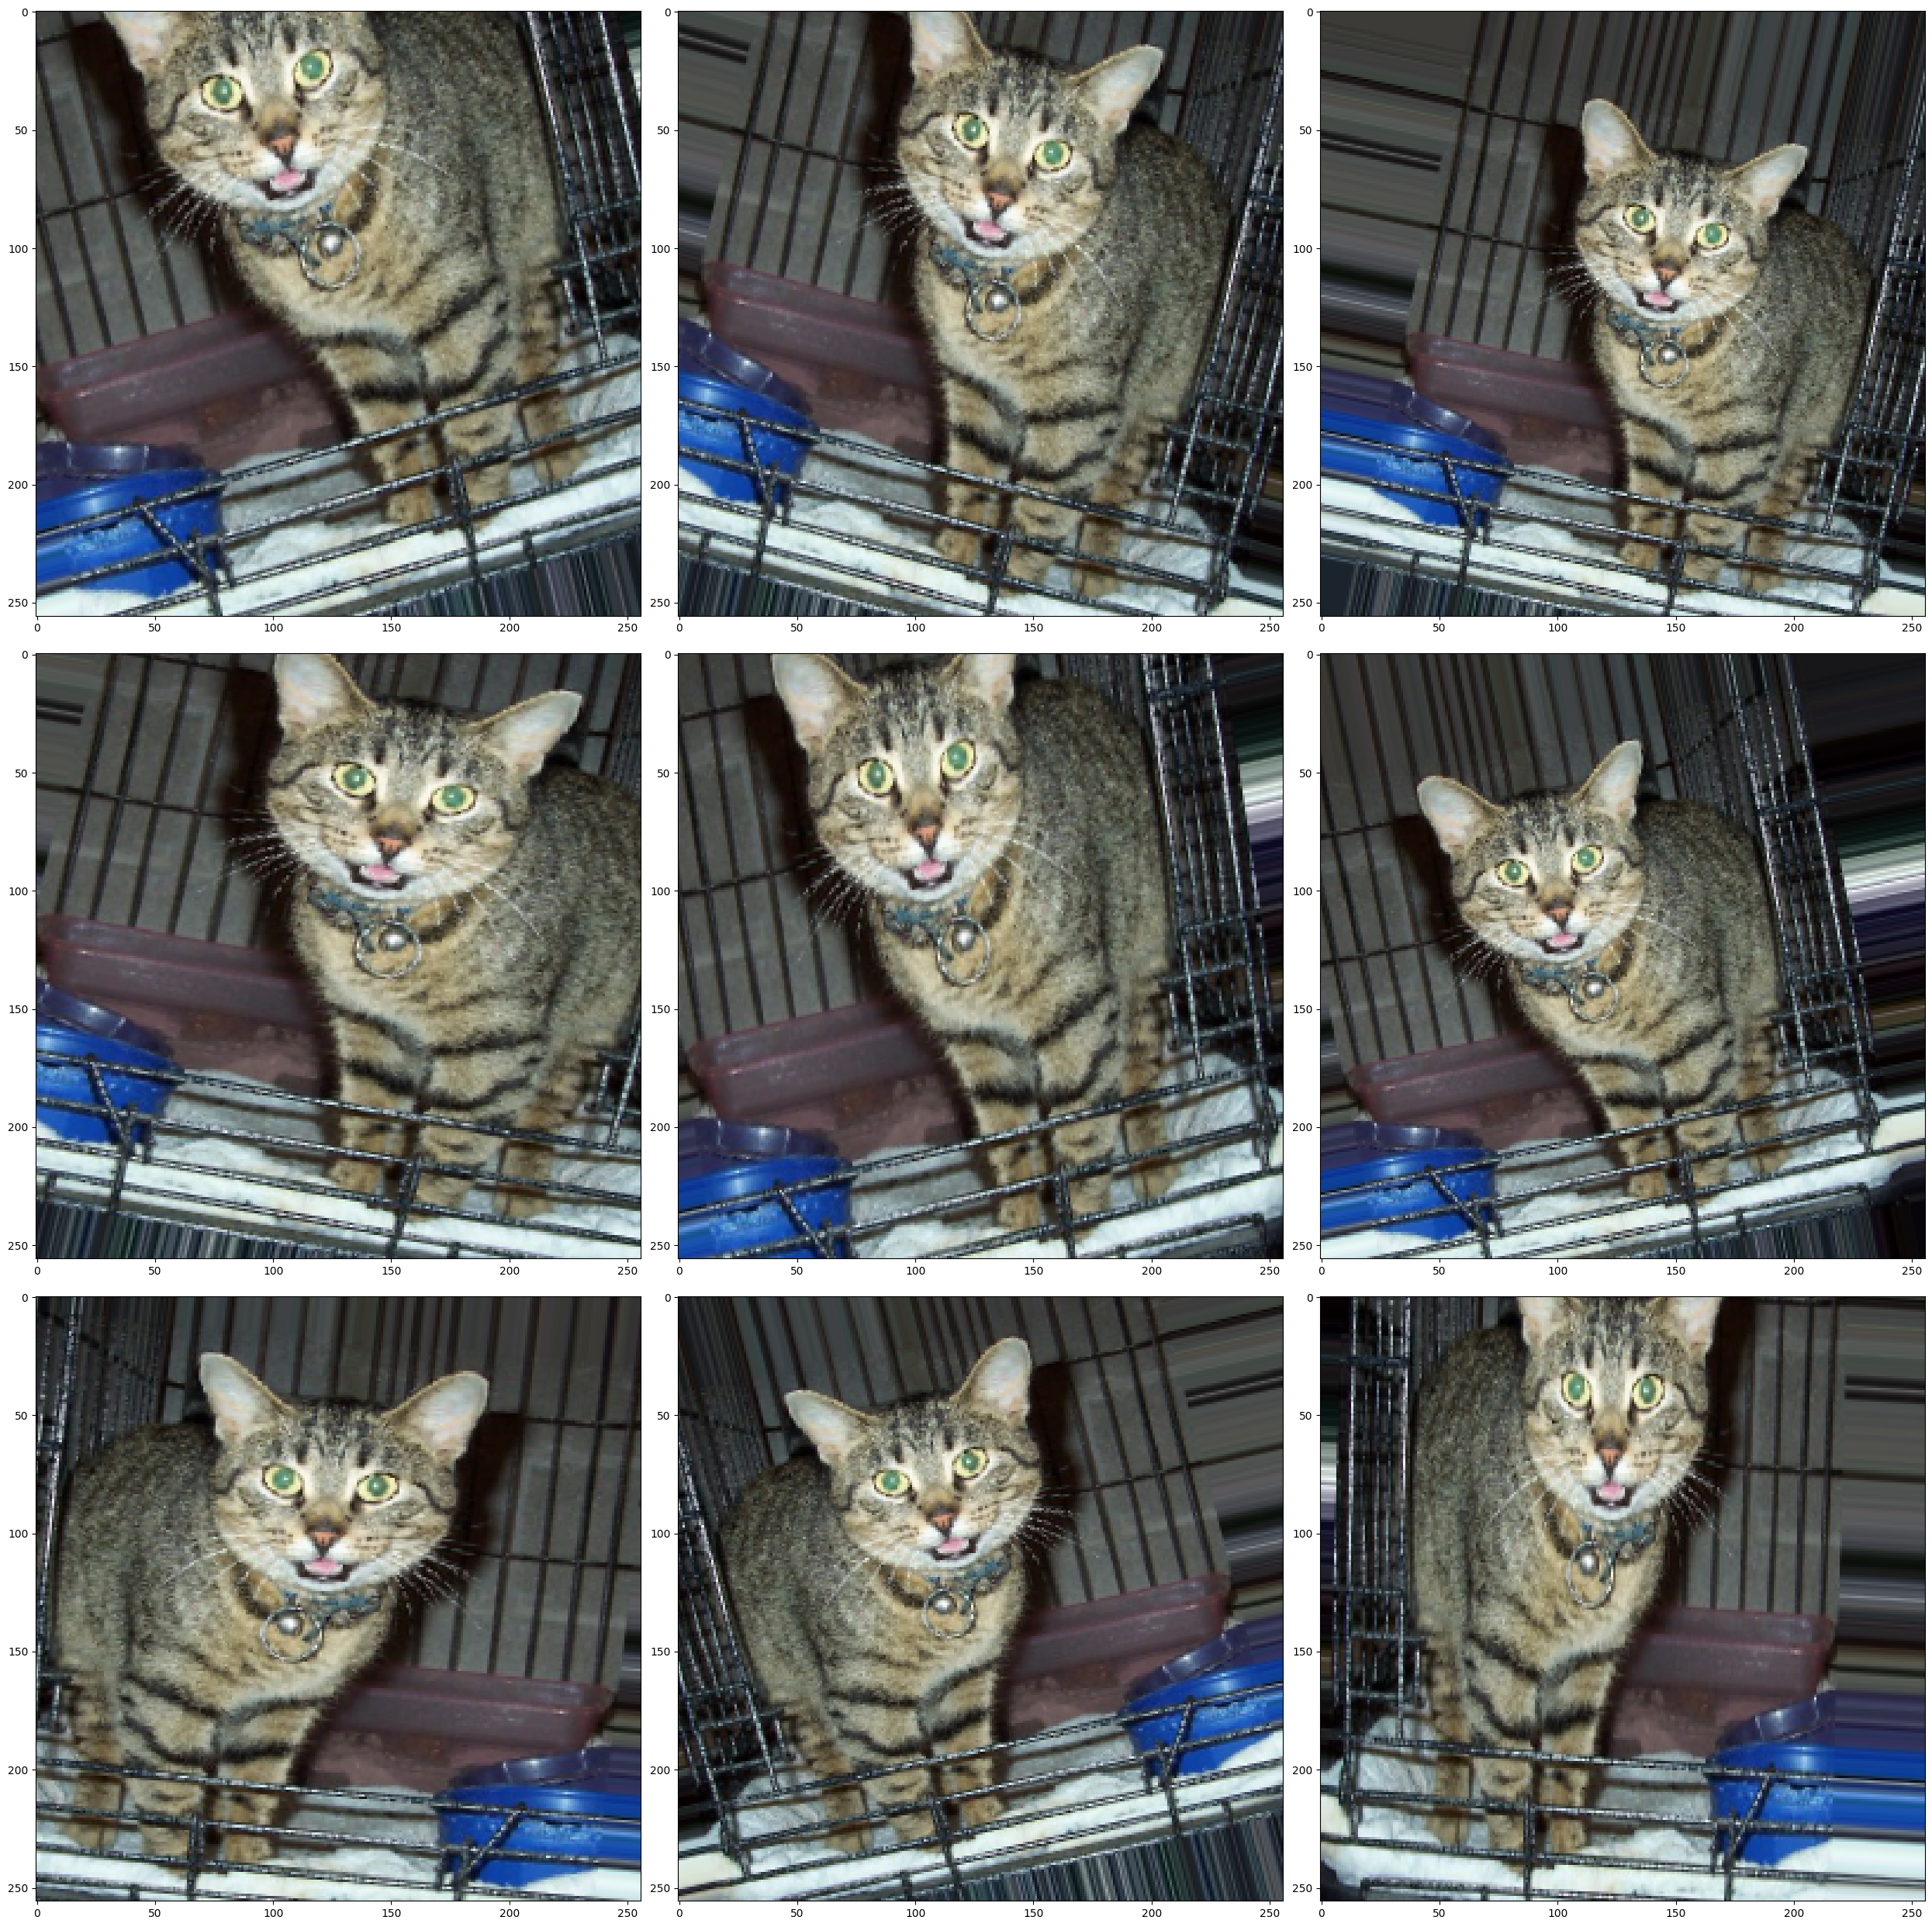

In [34]:
df_img_example = df_train.sample(n=1).reset_index(drop=True)
df_example_generator = train_datagen_2.flow_from_dataframe(
    df_img_example,
    directory=None,
    x_col='path',
    y_col='label',
    class_mode='categorical'
)
plt.figure(figsize=(25, 25))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in df_example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

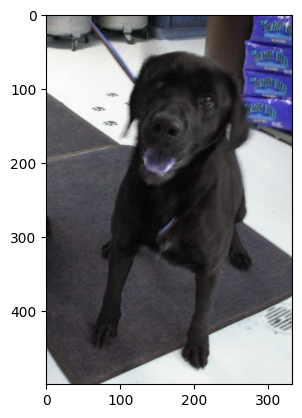

In [35]:
img_2 = cv2.imread("PetImages/Dog/12481.jpg")
plt.imshow(img_2)

In [36]:
from rembg import remove

input_path = 'PetImages/Dog/12481.jpg'
output_path = 'output.jpg'

with open(input_path, 'rb') as i:
    with open(output_path, 'wb') as o:
        input = i.read()
        output = remove(input)
        o.write(output)

100%|███████████████████████████████████████| 176M/176M [00:00<00:00, 78.8GB/s]


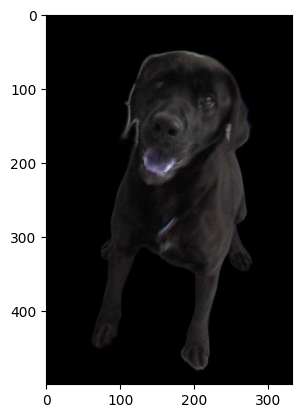

In [37]:
img_3 = cv2.imread("output.jpg")
plt.imshow(img_3)

In [38]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=None,
    x_col="path",
    y_col="label",
    target_size=(image_size, image_size),
    color_mode="rgb",
    class_mode='binary',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='training'
)

Found 1441 validated image filenames belonging to 2 classes.


In [39]:
valid_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=None,
    x_col="path",
    y_col="label",
    target_size=(image_size, image_size),
    color_mode="rgb",
    class_mode="binary",
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 360 validated image filenames belonging to 2 classes.


In [40]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=None,
    x_col="path",
    y_col="label",
    target_size=(image_size, image_size),
    color_mode="rgb",
    class_mode='binary', #None
    batch_size=1,
    shuffle=False,
    seed=42
)

Found 201 validated image filenames belonging to 2 classes.


In [41]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

87910968/87910968 [==============================] - 1s 0us/step


Ready for My model

In [42]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [43]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

In [44]:
x = Dense(1024, activation='sigmoid')(x)
predictions = Dense(1, activation='sigmoid')(x)

In [45]:
model_V3 = Model(inputs=base_model.input, outputs=predictions)

In [46]:
for layer in base_model.layers:
    layer.trainable = False

In [47]:
model_V3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [48]:
es_callback = keras.callbacks.EarlyStopping(patience=20)

In [49]:
model_V3.compile(loss="binary_crossentropy",
                      optimizer=Adam(learning_rate=0.00001),
                      metrics=['accuracy'])

In [50]:
train_steps_size = train_generator.n//train_generator.batch_size
validation_steps_size = valid_generator.n//valid_generator.batch_size

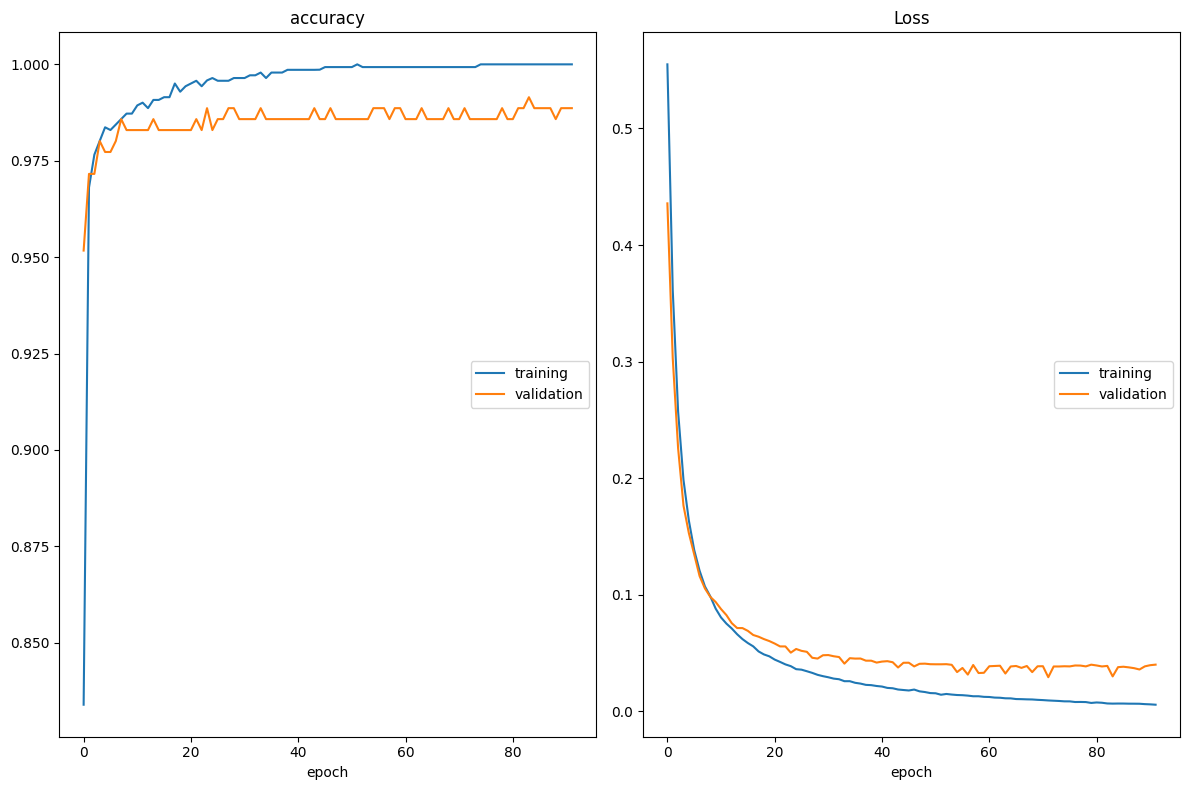

accuracy
	training         	 (min:    0.834, max:    1.000, cur:    1.000)
	validation       	 (min:    0.952, max:    0.991, cur:    0.989)
Loss
	training         	 (min:    0.005, max:    0.555, cur:    0.005)
	validation       	 (min:    0.029, max:    0.436, cur:    0.040)
45/45 [==============================] - 9s 200ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0399 - val_accuracy: 0.9886


In [51]:
history = model_V3.fit_generator(train_generator,
                                          validation_data = valid_generator,
                                          steps_per_epoch = train_steps_size,
                                          validation_steps = validation_steps_size,
                                          epochs=epochs,
                                          callbacks=[es_callback, PlotLossesKeras()]
                                          )

Text(0.5, 1.0, 'Model InceptionV3 (accuracy - loss)')

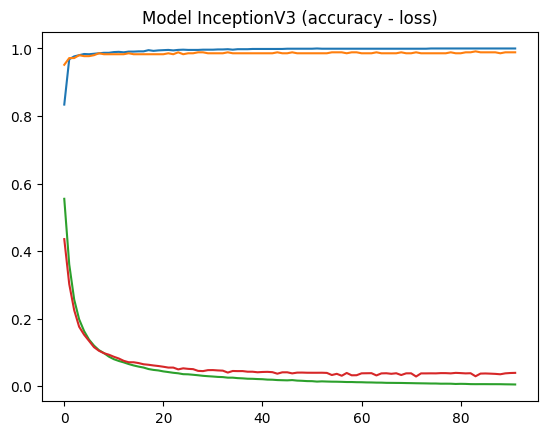

In [52]:
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model InceptionV3 (accuracy - loss)")

In [53]:
model_V3.evaluate_generator(generator=valid_generator, steps=validation_steps_size)

<ipython-input-53-118e7f60f3b0>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model_V3.evaluate_generator(generator=valid_generator, steps=validation_steps_size)


[0.03984048590064049, 0.9886363744735718]

In [54]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_1
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_normalization_14
5

In [55]:
for layer in model_V3.layers[:249]:
   layer.trainable = False
for layer in model_V3.layers[249:]:
   layer.trainable = True

In [56]:
model_V3.compile(loss="binary_crossentropy",
                      optimizer=Adam(learning_rate=0.00001),
                      metrics=['accuracy'])

In [57]:
train_steps_size = train_generator.n//train_generator.batch_size
validation_steps_size = valid_generator.n//valid_generator.batch_size

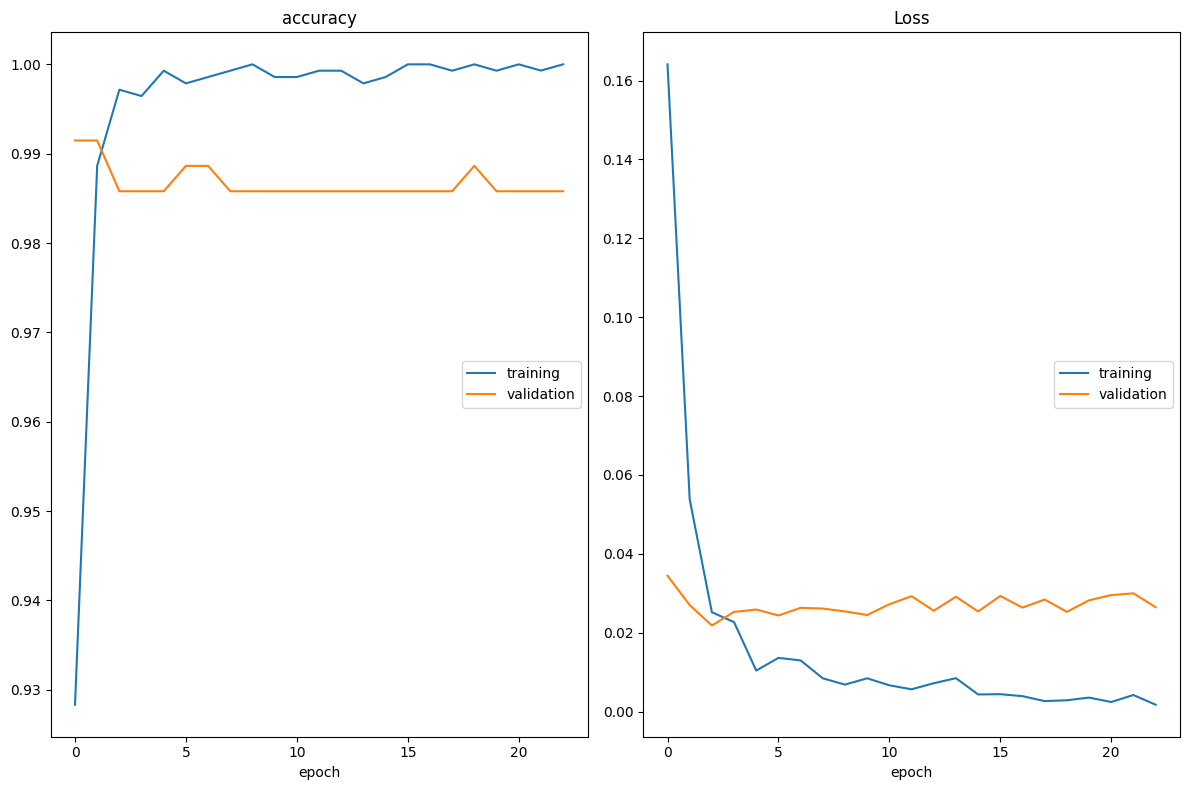

accuracy
	training         	 (min:    0.928, max:    1.000, cur:    1.000)
	validation       	 (min:    0.986, max:    0.991, cur:    0.986)
Loss
	training         	 (min:    0.002, max:    0.164, cur:    0.002)
	validation       	 (min:    0.022, max:    0.034, cur:    0.026)
45/45 [==============================] - 9s 210ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0265 - val_accuracy: 0.9858


In [58]:
history_2 = model_V3.fit_generator(train_generator,
                                          validation_data = valid_generator,
                                          steps_per_epoch = train_steps_size,
                                          validation_steps = validation_steps_size,
                                          epochs=80,
                                          callbacks=[es_callback, PlotLossesKeras()]
                                          )

Text(0.5, 1.0, 'Model InceptionV3 (accuracy - loss)')

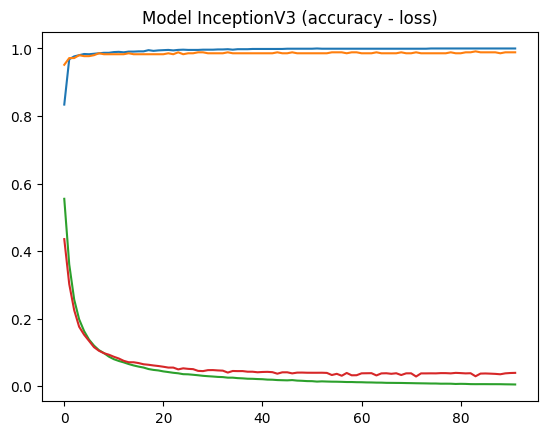

In [59]:
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model InceptionV3 (accuracy - loss)")

In [60]:
model_V3.save('model_V3.h5')

In [61]:
model_V3.evaluate_generator(generator=valid_generator, steps=validation_steps_size)

<ipython-input-61-118e7f60f3b0>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model_V3.evaluate_generator(generator=valid_generator, steps=validation_steps_size)


[0.026526857167482376, 0.9857954382896423]

In [65]:
predictions = model_V3.predict_generator(test_generator)
print(predictions)

<ipython-input-65-2e9b61bce50a>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model_V3.predict_generator(test_generator)


[[9.99599159e-01]
 [4.40377080e-05]
 [9.99403238e-01]
 [1.02893464e-05]
 [9.99871731e-01]
 [9.86873686e-01]
 [1.74632907e-04]
 [9.99054134e-01]
 [9.90015734e-03]
 [9.98893440e-01]
 [3.18357488e-04]
 [9.99601901e-01]
 [9.39863741e-01]
 [3.14424746e-04]
 [3.79291072e-04]
 [2.64925580e-03]
 [2.72635025e-05]
 [3.69980000e-03]
 [9.99674439e-01]
 [9.99665618e-01]
 [8.25757888e-05]
 [9.98795033e-01]
 [9.98237848e-01]
 [9.96532798e-01]
 [9.98981893e-01]
 [5.92019969e-05]
 [9.78120625e-01]
 [4.91898623e-04]
 [7.67709629e-04]
 [2.09592923e-04]
 [1.39184622e-05]
 [9.99797761e-01]
 [2.30262449e-04]
 [9.97698486e-01]
 [9.99819696e-01]
 [1.21990487e-03]
 [9.60344672e-01]
 [9.99722779e-01]
 [9.98885453e-01]
 [1.11940390e-04]
 [7.87483950e-05]
 [9.99361455e-01]
 [1.83874494e-04]
 [1.17170464e-04]
 [9.99830604e-01]
 [9.99961376e-01]
 [5.85135385e-05]
 [9.96510684e-01]
 [7.71194100e-05]
 [9.99901175e-01]
 [9.99701440e-01]
 [8.50293378e-04]
 [9.99863029e-01]
 [1.55635236e-03]
 [2.98671745e-04]
 [9.998654

In [66]:
threshold = 0.55
binary_predictions = [1 if pred > threshold else 0 for pred in predictions]

In [67]:
num_predictions = len(binary_predictions)
test_image_ids = list(range(1, num_predictions + 1))
data = {'id': test_image_ids, 'label': binary_predictions}
df = pd.DataFrame(data)
print(df)

      id  label
0      1      1
1      2      0
2      3      1
3      4      0
4      5      1
..   ...    ...
196  197      1
197  198      1
198  199      0
199  200      0
200  201      1

[201 rows x 2 columns]


In [68]:
csv_file_path = 'predict_result.csv'
df.to_csv(csv_file_path, index=False)

In [69]:
cm = confusion_matrix(test_generator.classes, binary_predictions)

In [70]:
clr = classification_report(test_generator.labels, binary_predictions, labels=[0, 1])

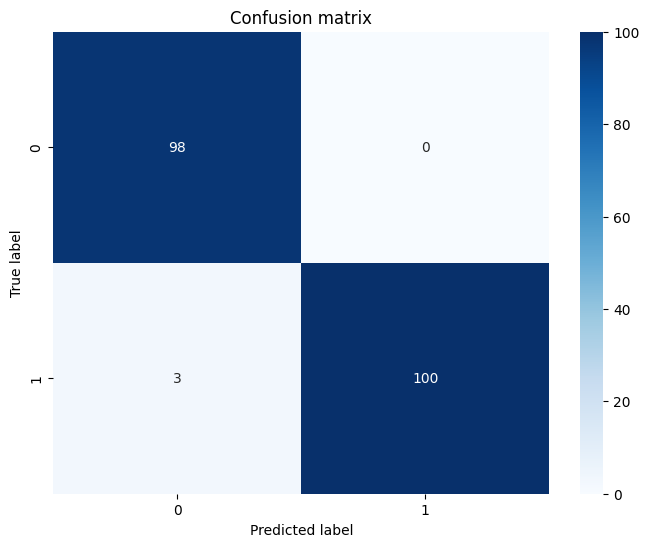

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        98
           1       1.00      0.97      0.99       103

    accuracy                           0.99       201
   macro avg       0.99      0.99      0.99       201
weighted avg       0.99      0.99      0.99       201



In [71]:
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cbar=True, cmap='Blues',xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

print("Classification Report:\n----------------------\n", clr)